In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prices = pd.read_csv('vbr16_19.csv', index_col='Date')

In [3]:
# calculate cumulative returns
cumret = np.log(prices).diff().cumsum()+1
cumret.dropna(how='all', inplace=True)
cumret.dropna(axis=1, inplace=True)

In [4]:
# define a set of formation\trading periods
periods = [('2016-07-01', '2017-07-01', '2017-07-01', '2018-01-01'),
           ('2016-08-01', '2017-08-01', '2017-08-01', '2018-02-01'),
           ('2016-09-01', '2017-09-01', '2017-09-01', '2018-03-01'),
           ('2016-10-01', '2017-10-01', '2017-10-01', '2018-04-01'),
           ('2016-11-01', '2017-11-01', '2017-11-01', '2018-05-01'),
           ('2016-12-01', '2017-12-01', '2017-12-01', '2018-06-01'),
           ('2017-01-01', '2018-01-01', '2018-01-01', '2018-07-01'),
           ('2017-02-01', '2018-02-01', '2018-02-01', '2018-08-01'),
           ('2017-03-01', '2018-03-01', '2018-03-01', '2018-09-01'),
           ('2017-04-01', '2018-04-01', '2018-04-01', '2018-10-01'),
           ('2017-05-01', '2018-05-01', '2018-05-01', '2018-11-01'),
           ('2017-06-01', '2018-06-01', '2018-06-01', '2018-12-01'),
           ('2017-07-01', '2018-07-01', '2018-07-01', '2019-01-01'),
           ('2017-08-01', '2018-08-01', '2018-08-01', '2019-02-01'),
           ('2017-09-01', '2018-09-01', '2018-09-01', '2019-03-01'),
           ('2017-10-01', '2018-10-01', '2018-10-01', '2019-04-01'),
           ('2017-11-01', '2018-11-01', '2018-11-01', '2019-05-01'),
           ('2017-12-01', '2018-12-01', '2018-12-01', '2019-06-01'),
           ('2018-01-01', '2019-01-01', '2019-01-01', '2019-07-01'),
           ('2018-02-01', '2019-02-01', '2019-02-01', '2019-08-01'),
           ('2018-03-01', '2019-03-01', '2019-03-01', '2019-09-01'),
           ('2018-04-01', '2019-04-01', '2019-04-01', '2019-10-01'),
           ('2018-05-01', '2019-05-01', '2019-05-01', '2019-11-01'),
           ('2018-06-01', '2019-06-01', '2019-06-01', '2019-12-01'),
           ('2018-07-01', '2019-07-01', '2019-07-01', '2020-01-01')]

In [5]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def select_pairs(cumret_form, cumret_trade):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint

    cols = ['CADF p-value', 'Num zero-crossings', 'Pearson r', 'Spread mean', 'Spread SD', 'Hurst Exponent', 
            'Half-life of mean reversion', 'Hedge ratio', 'Current spread price']
    pairs = pd.DataFrame(columns=cols)

    for s1 in cumret_form.columns:
        for s2 in cumret_form.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(cumret_form[s1], cumret_form[s2])[1]
                if cadf_p<0.01 and (f'{s2}-{s1}' not in pairs.index): # stop if pair already added as s2-s1
                    res = OLS(cumret_form[s1], add_constant(cumret_form[s2])).fit()
                    hedge_ratio = res.params[s2]
                    if hedge_ratio > 0: # hedge ratio should be posititve
                        spread_form = cumret_form[s1] - hedge_ratio*cumret_form[s2]
                        spread_mean = spread_form.mean()
                        spread_std = spread_form.std()
                        hurst = compute_Hc(spread_form)[0]
                        if hurst<0.5:
                            halflife = calculate_halflife(spread_form)
                            if halflife>1 and halflife<12:
                                # subtract the mean to calculate num_crossings
                                spread_nm = spread_form - spread_form.mean() 
                                num_crossings = (spread_nm.values[1:] * spread_nm.values[:-1] < 0).sum()
                                if num_crossings>len(cumret_form.index)/252*12: 
                                    pearson_r = np.corrcoef(cumret_form[s1], cumret_form[s2])[0][1]
                                    pairs.loc[f'{s1}-{s2}'] = [cadf_p, num_crossings, pearson_r, spread_mean, 
                                                               spread_std, hurst, halflife, hedge_ratio, 
                                                               spread_form[-1]]
                                
    return pairs

In [6]:
'''
cols = ['CADF p-value', 'Num zero-crossings', 'Pearson r', 'Spread mean', 'Spread SD', 'Hurst Exponent', 
        'Half-life of mean reversion', 'Hedge ratio', 'Current spread price', 'Deviation from the mean (SD)', 'TTC']
data = pd.DataFrame(columns=cols)

for form_start,form_end,trade_start,trade_end in periods:
    print(f'Processing period {form_start} : {trade_end}')
    # select prices for formation and trading periods
    cumret_tmp = cumret[form_start:trade_end]
    cumret_tmp = cumret_tmp/cumret_tmp.iloc[0]
    cumret_form = cumret_tmp[:form_end]
    cumret_trade = cumret_tmp[trade_start:]
    
    # select potential pairs
    pairs_tmp = select_pairs(cumret_form, cumret_trade)
    
    # calculate current deviation from the mean (in standard deviations)
    pairs_tmp['Deviation from the mean (SD)'] = (pairs_tmp['Current spread price'] - 
                                                 pairs_tmp['Spread mean'])/pairs_tmp['Spread SD']
    # separate deviated pairs
    deviated_pairs = pairs_tmp[(abs(pairs_tmp['Deviation from the mean (SD)'])>=2) & 
                               (abs(pairs_tmp['Deviation from the mean (SD)'])<=3)].copy()
    
    # calculate time to converge (in days)
    for pair in deviated_pairs.index:
        s1,s2 = parse_pair(pair)
        hedge_ratio = deviated_pairs.loc[pair]['Hedge ratio']
        spread_mean = deviated_pairs.loc[pair]['Spread mean']
        spread_dev = deviated_pairs.loc[pair]['Deviation from the mean (SD)']
        spread_trade = cumret_trade[s1] - hedge_ratio*cumret_trade[s2]
        # calculate time to convergence
        if spread_dev<0 and len(spread_trade[spread_trade>spread_mean])>0:
            deviated_pairs.loc[pair, ['TTC']] = (pd.to_datetime(spread_trade[spread_trade>spread_mean].index[0])
                                                 - pd.to_datetime(trade_start)).days
        elif spread_dev>0 and len(spread_trade[spread_trade<spread_mean])>0:
            deviated_pairs.loc[pair, ['TTC']] = (pd.to_datetime(spread_trade[spread_trade<spread_mean].index[0])
                                                 - pd.to_datetime(trade_start)).days
        else:
            deviated_pairs.loc[pair, ['TTC']] = 1000
    
    # save data
    data = pd.concat([data,deviated_pairs], axis=0, ignore_index=True)
'''

"\ncols = ['CADF p-value', 'Num zero-crossings', 'Pearson r', 'Spread mean', 'Spread SD', 'Hurst Exponent', \n        'Half-life of mean reversion', 'Hedge ratio', 'Current spread price', 'Deviation from the mean (SD)', 'TTC']\ndata = pd.DataFrame(columns=cols)\n\nfor form_start,form_end,trade_start,trade_end in periods:\n    print(f'Processing period {form_start} : {trade_end}')\n    # select prices for formation and trading periods\n    cumret_tmp = cumret[form_start:trade_end]\n    cumret_tmp = cumret_tmp/cumret_tmp.iloc[0]\n    cumret_form = cumret_tmp[:form_end]\n    cumret_trade = cumret_tmp[trade_start:]\n    \n    # select potential pairs\n    pairs_tmp = select_pairs(cumret_form, cumret_trade)\n    \n    # calculate current deviation from the mean (in standard deviations)\n    pairs_tmp['Deviation from the mean (SD)'] = (pairs_tmp['Current spread price'] - \n                                                 pairs_tmp['Spread mean'])/pairs_tmp['Spread SD']\n    # separate deviat

In [7]:
data = pd.read_csv('rollingpairs.csv', index_col=0)

In [8]:
data

,CADF p-value,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio,Current spread price,Deviation from the mean (SD),TTC
0,0.003873,31.0,0.933092,0.240379,0.034829,0.330736,4.898213,0.706112,0.143163,-2.791243,1000.0
1,0.000444,22.0,0.867905,0.570653,0.045347,0.394838,9.681226,0.486696,0.437681,-2.932337,79.0
2,0.009764,34.0,0.846846,-0.001957,0.048552,0.452761,7.524574,1.080503,-0.101822,-2.056874,81.0
3,0.000206,19.0,0.890008,0.377280,0.041623,0.373441,8.123112,0.619026,0.283887,-2.243756,52.0
4,0.001584,27.0,0.868094,0.393249,0.045317,0.380747,9.155597,0.591614,0.290015,-2.278064,33.0
...,...,...,...,...,...,...,...,...,...,...,...
5390,0.009788,31.0,0.765737,0.615675,0.025692,0.282791,5.623571,0.396708,0.669665,2.101414,24.0
5391,0.006933,36.0,0.825817,-0.297070,0.049065,0.334352,5.487688,1.218671,-0.186452,2.254502,1000.0
5392,0.007512,30.0,0.821777,-0.556682,0.049576,0.311957,5.333747,1.524057,-0.437854,2.396862,39.0
5393,0.007054,22.0,0.800334,0.482605,0.052164,0.274762,5.348376,0.413268,0.633915,2.900639,1000.0


In [9]:
# filter too big and too small hedge ratios
data = data[(data['Hedge ratio']<3) & (data['Hedge ratio'] > 0.33)]

In [10]:
data.dtypes

CADF p-value                    float64
Num zero-crossings              float64
Pearson r                       float64
Spread mean                     float64
Spread SD                       float64
Hurst Exponent                  float64
Half-life of mean reversion     float64
Hedge ratio                     float64
Current spread price            float64
Deviation from the mean (SD)    float64
TTC                             float64
dtype: object

In [11]:
data.describe()

,CADF p-value,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio,Current spread price,Deviation from the mean (SD),TTC
count,3.391000e+03,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,4.669767e-03,34.287231,0.819748,0.180630,0.039872,0.350948,6.133104,0.837264,0.184173,0.195728,437.831318
std,2.989468e-03,7.820898,0.131153,0.488383,0.029702,0.059348,1.596176,0.468769,0.520701,2.343237,464.854478
min,2.719962e-09,12.000000,0.177672,-3.391894,0.008602,0.184066,2.451611,0.330126,-4.613944,-2.999054,1.000000
25%,1.960473e-03,29.000000,0.770322,-0.016561,0.025428,0.308397,5.139884,0.489764,-0.028276,-2.246530,34.500000
50%,4.603441e-03,34.000000,0.855841,0.311064,0.032791,0.342270,5.721723,0.703029,0.318291,2.037733,104.000000
75%,7.188435e-03,39.000000,0.912789,0.525274,0.045160,0.389086,6.812581,1.041912,0.541398,2.306736,1000.000000
max,9.994954e-03,70.000000,0.992213,1.349127,0.605029,0.499893,11.950763,2.943180,1.801556,2.998336,1000.000000


In [12]:
data.corr()

,CADF p-value,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio,Current spread price,Deviation from the mean (SD),TTC
CADF p-value,1.000000,-0.122625,-0.026856,-0.001021,0.041163,0.003059,0.275411,-0.005565,-0.001239,0.011753,0.043144
Num zero-crossings,-0.122625,1.000000,0.277889,-0.050403,-0.251896,-0.263522,-0.454500,0.027675,-0.045043,0.018950,-0.054797
Pearson r,-0.026856,0.277889,1.000000,-0.244475,-0.327058,-0.254842,-0.317679,0.213109,-0.224228,0.029699,-0.059043
Spread mean,-0.001021,-0.050403,-0.244475,1.000000,-0.360838,0.032332,0.076576,-0.959279,0.975957,0.084685,0.023734
Spread SD,0.041163,-0.251896,-0.327058,-0.360838,1.000000,0.238041,0.207286,0.371108,-0.375552,-0.061242,0.071597
Hurst Exponent,0.003059,-0.263522,-0.254842,0.032332,0.238041,1.000000,0.324809,0.022833,0.043929,0.032549,0.053368
Half-life of mean reversion,0.275411,-0.454500,-0.317679,0.076576,0.207286,0.324809,1.000000,-0.063727,0.057800,-0.075032,0.055702
Hedge ratio,-0.005565,0.027675,0.213109,-0.959279,0.371108,0.022833,-0.063727,1.000000,-0.918121,-0.063164,-0.027767
Current spread price,-0.001239,-0.045043,-0.224228,0.975957,-0.375552,0.043929,0.057800,-0.918121,1.000000,0.258924,0.028900
Deviation from the mean (SD),0.011753,0.018950,0.029699,0.084685,-0.061242,0.032549,-0.075032,-0.063164,0.258924,1.000000,0.051834


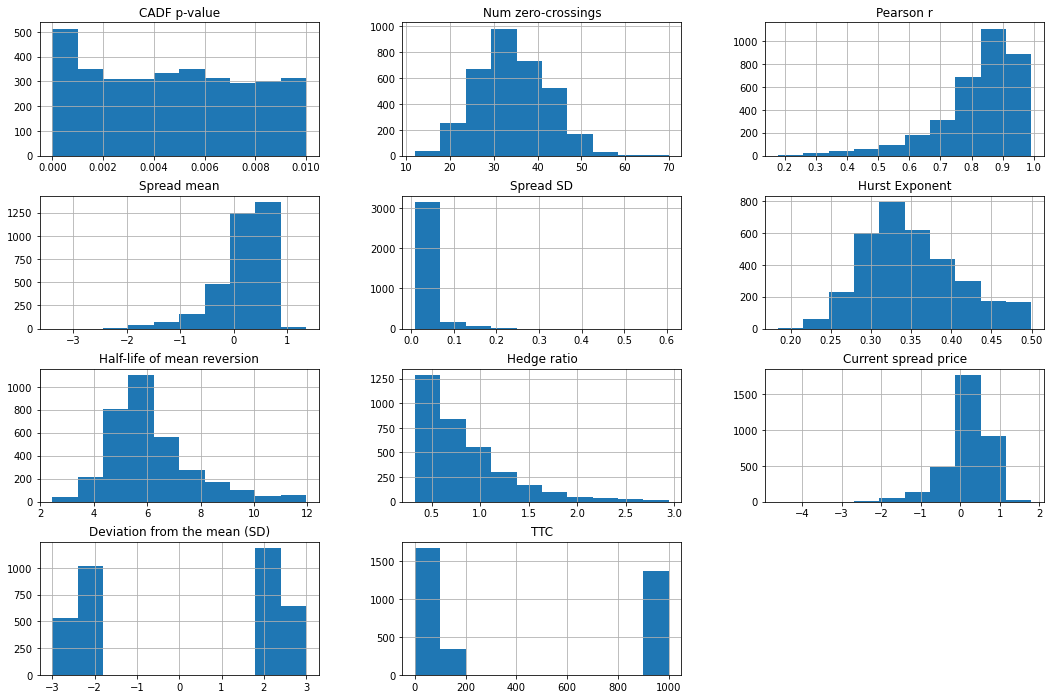

In [13]:
_ = data.hist(figsize=(18,12))

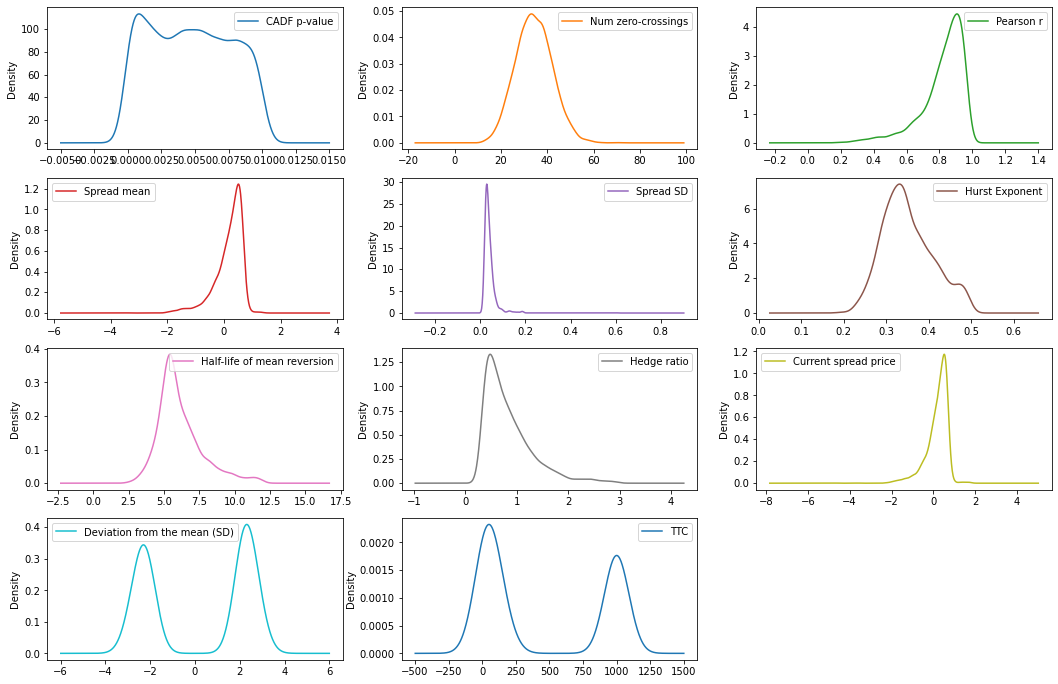

In [14]:
_ = data.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(18,12))

In [15]:
len(data.columns)

11

# ML Classification

In [16]:
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [17]:
X = data.values[:,:10]
y = data.values[:,10]
binarizer = Binarizer(threshold=30).fit(y.reshape(-1,1))
y_bin = binarizer.transform(y.reshape(-1,1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, shuffle=True, 
                                                    random_state=14, stratify=y_bin)

In [18]:
# benchmark score
len(y_train[y_train==0]) / len(y_train)

0.22882427307206069

In [19]:
def top10_accuracy(estimator, X, y):
    '''
    compute accuracy of top 10 predictions:
    select top 10 samples with the highest probability of belonging to class 0
    return the fraction of samples actually belonging to class 0
    '''
    pred_prob = estimator.predict_proba(X)[:,0]
    top10_ind = np.argsort(pred_prob)[-10:]
    top10_prob = pred_prob[top10_ind]
    # if at least one of top ten probabilities is less than 0.5, return 0 score
    if len(top10_prob[top10_prob<0.5])>0:
        score = 0
    else:
        score = sum(y[top10_ind] == np.zeros(10))/10
    
    return score

In [20]:
def test_models_class(models, X=X_train, y=y_train, n_folds=10, scoring=top10_accuracy, seed=45):
    '''
    cross-validate each model in models using n_folds and scoring
    '''
    
    results = []
    names = []
    for name,model in models:
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        
    return results, names

In [21]:
models = []
models.append(('LR', LogisticRegressionCV(max_iter=1000, class_weight='balanced', scoring=top10_accuracy)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA_1', QuadraticDiscriminantAnalysis()))
models.append(('QDA_2', QuadraticDiscriminantAnalysis(reg_param=0.1)))
models.append(('KNN_1', KNeighborsClassifier()))
models.append(('KNN_2', KNeighborsClassifier(weights='distance')))
models.append(('CART_1', DecisionTreeClassifier(class_weight='balanced')))
models.append(('CART_2', DecisionTreeClassifier(max_features='auto', class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('GPC', GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1)))
models.append(('MLP_1', MLPClassifier(max_iter=5000)))
models.append(('MLP_2', MLPClassifier(alpha=1, max_iter=5000)))
models.append(('SVM', SVC(class_weight='balanced', probability=True)))

results,names = test_models_class(models)

LR: 0.25999999999999995 (0.066332495807108)
LDA: 0.0 (0.0)
QDA_1: 0.37999999999999995 (0.14696938456699069)
QDA_2: 0.0 (0.0)
KNN_1: 0.24 (0.128062484748657)
KNN_2: 0.23000000000000004 (0.10999999999999999)
CART_1: 0.27999999999999997 (0.12489995996796796)
CART_2: 0.22000000000000003 (0.07483314773547882)
NB: 0.27 (0.14866068747318506)
GPC: 0.0 (0.0)
MLP_1: 0.0 (0.0)
MLP_2: 0.0 (0.0)
SVM: 0.0 (0.0)


In [22]:
pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}', Pipeline([('scaler', PowerTransformer()),
                                                 (name,model)])))
    
results,names = test_models_class(pipelines)

scaledLR: 0.38 (0.10770329614269007)
scaledLDA: 0.0 (0.0)
scaledQDA_1: 0.30999999999999994 (0.13)
scaledQDA_2: 0.04 (0.12)
scaledKNN_1: 0.29 (0.157797338380595)
scaledKNN_2: 0.29000000000000004 (0.11357816691600547)
scaledCART_1: 0.34 (0.12000000000000001)
scaledCART_2: 0.28 (0.11661903789690602)
scaledNB: 0.05 (0.15000000000000002)
scaledGPC: 0.0 (0.0)
scaledMLP_1: 0.36 (0.19595917942265426)
scaledMLP_2: 0.0 (0.0)
scaledSVM: 0.0 (0.0)


In [23]:
pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}_pca4', Pipeline([('scaler', PowerTransformer()),
                                                 ('PCA', PCA(n_components=4)),
                                                 (name,model)])))
    
results,names = test_models_class(pipelines)

scaledLR_pca4: 0.36 (0.11135528725660045)
scaledLDA_pca4: 0.0 (0.0)
scaledQDA_1_pca4: 0.0 (0.0)
scaledQDA_2_pca4: 0.0 (0.0)
scaledKNN_1_pca4: 0.31 (0.14456832294800961)
scaledKNN_2_pca4: 0.27 (0.11874342087037916)
scaledCART_1_pca4: 0.25 (0.11180339887498948)
scaledCART_2_pca4: 0.19 (0.09433981132056604)
scaledNB_pca4: 0.0 (0.0)
scaledGPC_pca4: 0.0 (0.0)
scaledMLP_1_pca4: 0.0 (0.0)
scaledMLP_2_pca4: 0.0 (0.0)
scaledSVM_pca4: 0.0 (0.0)


In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

ensembles = []
ensembles.append(('ADA', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(class_weight='balanced')))
ensembles.append(('ET', ExtraTreesClassifier(class_weight='balanced')))


results,names = test_models_class(ensembles)

ADA: 0.03 (0.09)
GBM: 0.0 (0.0)
RF: 0.0 (0.0)
ET: 0.0 (0.0)


In [25]:
model = Pipeline([('scaler', PowerTransformer()),
                  ('LR', LogisticRegressionCV(max_iter=1000, class_weight='balanced', scoring=top10_accuracy))])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', PowerTransformer()),
                ('LR',
                 LogisticRegressionCV(class_weight='balanced', max_iter=1000,
                                      scoring=<function top10_accuracy at 0x7f28b5ee21f0>))])

In [26]:
top10_accuracy(model, X_test, y_test)

0.4